In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import requests
import json
import time
import pickle
import copy
import os
pd.set_option("display.max_columns", None)

In [ ]:
#os.chdir("") #Change working directory line

In [40]:
df_house = pd.read_csv("df_RE_latlongs_v3.csv", index_col = 0)
df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
df_min_distances = pd.read_csv("df_min_distances.csv", index_col = 0).set_index("SaleID")
driv_final_dict = pickle.load(open("df_driv_final.pkl", "rb"))
df_dist_time_all = pd.read_csv("df_dist_time_all.csv", index_col = 0) #migrate all code to use this dataframe
selected_features_dict = pickle.load(open("selected_features_dict.pkl", "rb"))

In [41]:
def find_important_features (model):
    return pd.DataFrame(np.array([model.feature_names_in_, model.feature_importances_]).T, columns = ["Name", "Importance"]).sort_values(by = "Importance", ascending = False)

In [42]:
def EDA_report (dist_data):
    display(dist_data.describe())
    num_cols = dist_data.shape[1]
    num_x_cols = num_cols - 1
    y_col = dist_data.columns[-1]
    print("Field correlation with SalePrice")
    print(dist_data.corr()[y_col].sort_values(ascending = False))
    print("-"*30)
    print()
    X = dist_data.iloc[:, :num_x_cols]
    y = dist_data[y_col]
    print("Random Forest Feature Importances")
    RFR = RandomForestRegressor()
    RFR.fit(X, y)
    print(find_important_features(RFR))
    print("-"*30)
    print()
    model = smf.ols(formula = y_col + " ~ " + "+".join(dist_data.columns[:-1].tolist()), data = dist_data).fit()
    summary = model.summary()
    print(summary)
    plt.figure(figsize = (20,20))
    sns.heatmap(dist_data.corr())
    return model
    

In [43]:
#Distance function from one lat long to another
def get_dist(from_location, to_location):
    #print("from",from_location)
    from_loc = from_location * (np.pi)/180
    #print("to", to_location)
    to_loc = to_location * np.pi/180
    delta = from_loc - to_loc
    phi = (from_loc[0] + to_loc[0])/2
    #print(from_loc)
    #print(to_loc)
    return np.sqrt((np.cos(phi)*delta[1])**2+delta[0]**2)*3963.19

In [44]:
def OSMR (lat_1, long_1, lat_2, long_2):
    # call the OSMR API
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{long_1},{lat_1};{long_2},{lat_2}?overview=false""")
    # then you load the response using the json libray
    # by default you get only one alternative so you access 0-th element of the `routes`
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]
    return pd.DataFrame(route_1)[["duration", "distance"]].values

In [45]:
def get_vif (df):
    return [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [46]:
s_SalePrice = df_min_distances.SalePrice

(df_min_distances
    .drop("SalePrice", axis = 1)
    .join(driv_final_dict["from_time"]
          .drop("SalePrice", axis = 1)
          .add_suffix("_time")
          )
    .join(s_SalePrice)
)#.to_csv("df_dist_time_all.csv")

Prop_Addr  Arts_dist  Elem_School_dist  Golf_dist  Gym_dist  \
SaleID                                                                         
2        4507 EVEREST  AVE   3.242633          1.929371   0.715416  1.448247   
3        4513 EVEREST  AVE   3.242633          1.929371   0.715416  1.448247   
18       4421 EVEREST  CIR   3.236729          1.937266   0.734943  1.448792   
19       4415 EVEREST  CIR   3.223320          1.928103   0.746873  1.436837   
20       4409 EVEREST  CIR   3.210345          1.921135   0.760642  1.426223   
...                    ...        ...               ...        ...       ...   
22743     434 KEN MARIL RD   2.710221          1.761681   1.892068  1.667317   
22749     602 KEN MARIL RD   2.727933          1.827909   1.934535  1.788531   
22756     706 KEN MARIL RD   2.741914          1.873802   1.965446  1.867632   
22768        3502 JEWEL DR   2.444105          1.690544   1.721184  1.937188   
22888   3420 E LINCOLN WAY   2.472949          3.204124   2.832035  2.734416   

        High_School_dist  Historic_dist  ISU_dist  Library_dist  Medical_dist  \
SaleID                                                                          
2               2.317200       3.473294  2.669473      3.007250      3.450440   
3               2.317200       3.473294  2.669473      3.007250      3.450440   
18              2.317822       3.475868  2.661876      2.998683      3.454870   
19              2.305862       3.464514  2.648265      2.984989      3.444188   
20              2.295222       3.454702  2.634851      2.971348      3.435270   
...                  ...            ...       ...           ...           ...   
22743           3.869988       2.796317  3.483489      2.763528      3.173590   
22749           3.916392       2.824383  3.555786      2.780977      3.185848   
22756           3.947960       2.844926  3.604008      2.794733      3.195877   
22768           3.695415       2.563125  3.417079      2.496236      2.888296   
22888           3.698796       2.596955  4.147193      2.478685      2.475798   

        Movies_dist  Organic_Groceries_dist  Park_dist  Recreation_dist  \
SaleID                                                                    
2          4.410568                0.946375   2.108587         2.505024   
3          4.410568                0.946375   2.108587         2.505024   
18         4.409409                0.959585   2.129966         2.504915   
19         4.396939                0.953473   2.131368         2.492742   
20         4.385537                0.950202   2.135974         2.481791   
...             ...                     ...        ...              ...   
22743      1.840600                2.801631   2.393877         2.823410   
22749      1.863953                2.839513   2.479932         2.851586   
22756      1.882900                2.866327   2.537348         2.872175   
22768      1.602370                2.602374   2.404160         2.590394   
22888      2.530623                2.945933   3.852586         2.734416   

        Religion_dist  Restaurant_dist  Shopping_dist  Spa_dist  \
SaleID                                                            
2            0.597284         1.420076       2.332287  2.289758   
3            0.597284         1.420076       2.332287  2.289758   
18           0.616119         1.421516       2.342817  2.300193   
19           0.628389         1.409838       2.334984  2.292310   
20           0.642360         1.399618       2.329606  2.286873   
...               ...              ...            ...       ...   
22743        2.596473         1.835929       2.382752  2.644254   
22749        2.501073         1.940505       2.397553  2.680053   
22756        2.439909         2.009589       2.410062  2.705693   
22768        2.151624         1.961777       2.110083  2.438930   
22888        0.914380         2.825823       2.369818  2.848689   

        Sports_Venue_dist                    Arts_name  \
SaleID          

Time  Service_Arts_time  Service_Elem_School_time  \
count  633.000000         633.000000                633.000000   
mean   146.818799           0.018957                  0.129542   
std     84.844802           0.136482                  0.336064   
min      1.300000           0.000000                  0.000000   
25%     83.500000           0.000000                  0.000000   
50%    118.000000           0.000000                  0.000000   
75%    203.800000           0.000000                  0.000000   
max    371.800000           1.000000                  1.000000   

       Service_Golf_time  Service_Gym_time  Service_High_School_time  \
count         633.000000        633.000000                633.000000   
mean            0.014218          0.189573                  0.012638   
std             0.118482          0.392273                  0.111796   
min             0.000000          0.000000                  0.000000   
25%             0.000000          0.000000                  0.000000   
50%             0.000000          0.000000                  0.000000   
75%             0.000000          0.000000                  0.000000   
max             1.000000          1.000000                  1.000000   

       Service_Historic_time  Service_ISU_time  Service_Library_time  \
count             633.000000        633.000000            633.000000   
mean                0.007899          0.003160              0.020537   
std                 0.088594          0.056165              0.141941   
min                 0.000000          0.000000              0.000000   
25%                 0.000000          0.000000              0.000000   
50%                 0.000000          0.000000              0.000000   
75%                 0.000000          0.000000              0.000000   
max                 1.000000          1.000000              1.000000   

       Service_Medical_time  Service_Organic_Groceries_time  \
count            633.000000                      633.000000   
mean               0.077409                        0.083728   
std                0.267451                        0.277199   
min                0.000000                        0.000000   
25%                0.000000                        0.000000   
50%                0.000000                        0.000000   
75%                0.000000                        0.000000   
max                1.000000                        1.000000   

       Service_Park_time  Service_Recreation_time  Service_Religion_time  \
count         633.000000               633.000000             633.000000   
mean            0.058452                 0.011058               0.115324   
std             0.234781                 0.104659               0.319665   
min             0.000000                 0.000000               0.000000   
25%             0.000000                 0.000000               0.000000   
50%             0.000000                 0.000000               0.000000   
75%             0.000000                 0.000000               0.000000   
max             1.000000                 1.000000               1.000000   

       Service_Restaurant_time  Service_Shopping_time  Service_Spa_time  \
count               633.000000             633.000000        633.000000   
mean                  0.112164               0.069510          0.075829   
std                   0.315818               0.254521          0.264934   
min                   0.000000               0.000000          0.000000   
25%                   0.000000               0.000000          0.000000   
50%                   0.000000               0.000000          0.000000   
75%                   0.000000               0.000000          0.000000   
max                   1.000000               1.000000          1.000000   

           SalePrice  
count     633.000000  
mean   258405.135861  
std    115168.322605  
min       900.000000  
25%    178000.000000  
50%    235000.000000  
75%    317000.000000  
max    

Field correlation with SalePrice
SalePrice                         1.000000
Service_Restaurant_time           0.215112
Time                              0.190147
Service_Park_time                 0.090913
Service_Religion_time             0.083622
Service_Gym_time                  0.055249
Service_Arts_time                 0.041981
Service_Library_time              0.041585
Service_Recreation_time           0.003028
Service_Golf_time                 0.000801
Service_ISU_time                 -0.010019
Service_Organic_Groceries_time   -0.010122
Service_Elem_School_time         -0.042963
Service_Historic_time            -0.043596
Service_High_School_time         -0.050323
Service_Shopping_time            -0.124359
Service_Spa_time                 -0.149071
Service_Medical_time             -0.191764
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
                              Name Importance
0                             Time   0.703421
13 

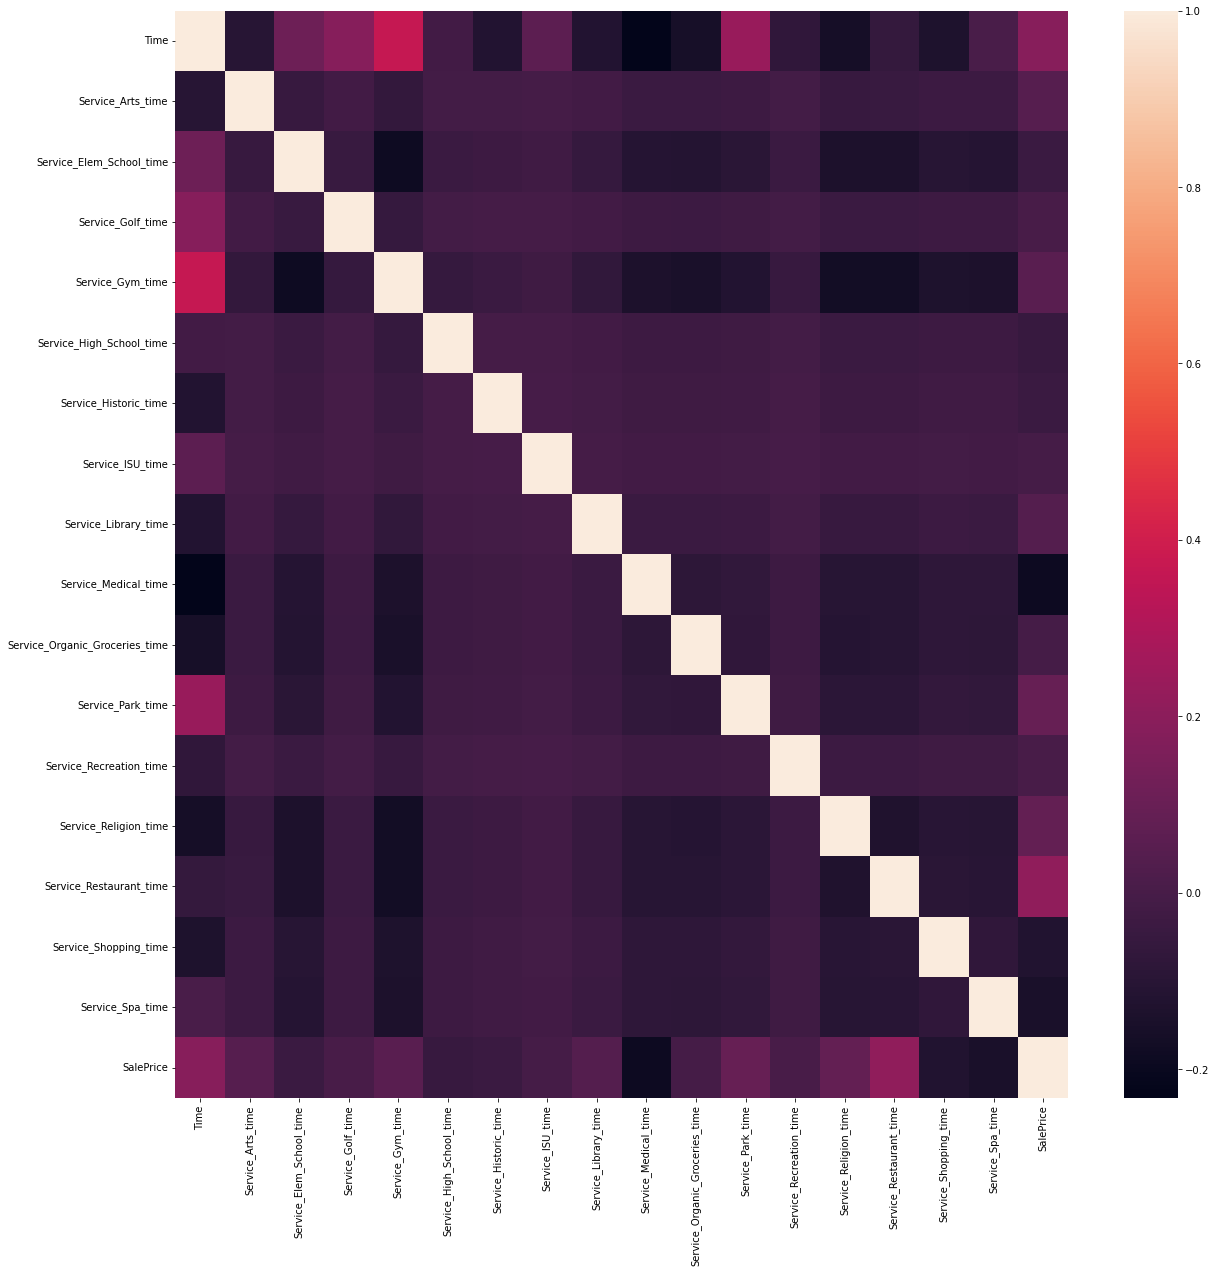

In [47]:
df_temp = df_dist_time_all.filter(regex = "time$|SaleID").drop(df_dist_time_all.filter(regex = "house").columns, axis = 1).stack().reset_index().set_axis(["SaleID", "Service", "Time"], axis = 1)


EDA_report(pd.get_dummies(
                        df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                        columns = ["Service"]
                        )
            .set_index("SaleID")
            .join(df_dist_time_all.SalePrice)
)

#EDA_report(pd.get_dummies(df_temp.drop("SalePrice", axis = 1), columns = ["Service"]).join(df_temp.pop("SalePrice")))


In [48]:
df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()].Service.value_counts(normalize = True)

Gym_time                  0.189573
Elem_School_time          0.129542
Religion_time             0.115324
Restaurant_time           0.112164
Organic_Groceries_time    0.083728
Medical_time              0.077409
Spa_time                  0.075829
Shopping_time             0.069510
Park_time                 0.058452
Library_time              0.020537
Arts_time                 0.018957
Golf_time                 0.014218
High_School_time          0.012638
Recreation_time           0.011058
Historic_time             0.007899
ISU_time                  0.003160
Name: Service, dtype: float64

In [49]:
#VIF for driving times
get_vif(pd.get_dummies(
                        df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                        columns = ["Service"]
                        )
            .set_index("SaleID")
        )

[1.595531118856093,
 1.0277992398414342,
 1.847339981302393,
 1.2430948488765023,
 2.8814673564527125,
 1.0501335075381106,
 1.0019444473555428,
 1.0404344959722969,
 1.026810045916706,
 1.106495434635917,
 1.193216543497222,
 1.6668560983123286,
 1.018807689171999,
 1.303701852180084,
 1.433187965536414,
 1.168699576286721,
 1.3707934977928666]

In [51]:
#VIF for point to point dist
get_vif(pd.get_dummies(df_temp.loc[df_temp.groupby("SaleID").Dist.idxmin()], columns = ["Service"]).set_index("SaleID"))

AttributeError: 'DataFrameGroupBy' object has no attribute 'Dist'

Time  Service_Arts_time  Service_Elem_School_time  \
count  633.000000         633.000000                633.000000   
mean   146.818799           0.018957                  0.129542   
std     84.844802           0.136482                  0.336064   
min      1.300000           0.000000                  0.000000   
25%     83.500000           0.000000                  0.000000   
50%    118.000000           0.000000                  0.000000   
75%    203.800000           0.000000                  0.000000   
max    371.800000           1.000000                  1.000000   

       Service_Golf_time  Service_Gym_time  Service_High_School_time  \
count         633.000000        633.000000                633.000000   
mean            0.014218          0.189573                  0.012638   
std             0.118482          0.392273                  0.111796   
min             0.000000          0.000000                  0.000000   
25%             0.000000          0.000000                  0.000000   
50%             0.000000          0.000000                  0.000000   
75%             0.000000          0.000000                  0.000000   
max             1.000000          1.000000                  1.000000   

       Service_Historic_time  Service_ISU_time  Service_Library_time  \
count             633.000000        633.000000            633.000000   
mean                0.007899          0.003160              0.020537   
std                 0.088594          0.056165              0.141941   
min                 0.000000          0.000000              0.000000   
25%                 0.000000          0.000000              0.000000   
50%                 0.000000          0.000000              0.000000   
75%                 0.000000          0.000000              0.000000   
max                 1.000000          1.000000              1.000000   

       Service_Medical_time  Service_Organic_Groceries_time  \
count            633.000000                      633.000000   
mean               0.077409                        0.083728   
std                0.267451                        0.277199   
min                0.000000                        0.000000   
25%                0.000000                        0.000000   
50%                0.000000                        0.000000   
75%                0.000000                        0.000000   
max                1.000000                        1.000000   

       Service_Park_time  Service_Recreation_time  Service_Religion_time  \
count         633.000000               633.000000             633.000000   
mean            0.058452                 0.011058               0.115324   
std             0.234781                 0.104659               0.319665   
min             0.000000                 0.000000               0.000000   
25%             0.000000                 0.000000               0.000000   
50%             0.000000                 0.000000               0.000000   
75%             0.000000                 0.000000               0.000000   
max             1.000000                 1.000000               1.000000   

       Service_Restaurant_time  Service_Shopping_time  Service_Spa_time  \
count               633.000000             633.000000        633.000000   
mean                  0.112164               0.069510          0.075829   
std                   0.315818               0.254521          0.264934   
min                   0.000000               0.000000          0.000000   
25%                   0.000000               0.000000          0.000000   
50%                   0.000000               0.000000          0.000000   
75%                   0.000000               0.000000          0.000000   
max                   1.000000               1.000000          1.000000   

       Closest_5_feature  Closest_all_feature  Central_historic_feature  \
count         633.000000           633.000000                633.000000   
mean          216.309131           356.66

Field correlation with SalePrice
SalePrice                         1.000000
Central_historic_feature          0.382961
Closest_all_feature               0.345661
Closest_5_feature                 0.262897
Service_Restaurant_time           0.215112
Time                              0.190147
Service_Park_time                 0.090913
Service_Religion_time             0.083622
Service_Gym_time                  0.055249
Service_Arts_time                 0.041981
Service_Library_time              0.041585
Service_Recreation_time           0.003028
Service_Golf_time                 0.000801
Service_ISU_time                 -0.010019
Service_Organic_Groceries_time   -0.010122
Service_Elem_School_time         -0.042963
Service_Historic_time            -0.043596
Service_High_School_time         -0.050323
Service_Shopping_time            -0.124359
Service_Spa_time                 -0.149071
Service_Medical_time             -0.191764
num_biz_480s_feature             -0.322112
num_biz_180s_feature 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     10.74
Date:                Sat, 24 Jun 2023   Prob (F-statistic):           3.71e-30
Time:                        15:23:21   Log-Likelihood:                -8175.3
No. Observations:                 633   AIC:                         1.639e+04
Df Residuals:                     611   BIC:                         1.649e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       4.292e+05   1.21e+05      3.538      0.000    1.91e+05    6.67e+05
Time                             120.0278    107.720      1.114      0.266     -91.518     331.574
Service_Arts_time               1.135e+05   2.98e+04      3.809      0.000     5.5e+04    1.72e+05
Service_Elem_School_time        2.473e+04    1.7e+04      1.454      0.146   -8673.523    5.81e+04
Service_Golf_time              -2290.2611   3.45e+04     -0.066      0.947   -7.01e+04    6.55e+04
Service_Gym_time               -6.469e+04   1.99e+04     -3.248      0.001   -1.04e+05   -2.56e+04
Service_High_School_time        1.887e+04   3.52e+04      0.537      0.592   -5.02e+04    8.79e+04
Service_Historic_time            4.91e+04   4.77e+04      1.030      0.304   -4.45e+04    1.43e+05
Service_ISU_time                7708.3738   6.87e+04      0.112      0.911   -1.27e+05    1.43e+05
Service_Library_time            8.231e+04      3e+04      2.744      0.006    2.34e+04    1.41e+05
Service_Medical_time            1.455e+04   2.21e+04      0.658      0.511   -2.89e+04     5.8e+04
Service_Organic_Groceries_time  2.126e+04   1.77e+04      1.199      0.231   -1.36e+04    5.61e+04
Service_Park_time               2.927e+04   2.02e+04      1.450      0.147   -1.04e+04    6.89e+04
Service_Recreation_time         7.655e+04   3.82e+04      2.004      0.045    1551.759    1.52e+05
Service_Religion_time           8020.2769   1.81e+04      0.444      0.657   -2.75e+04    4.35e+04
Service_Restaurant_time         7.747e+04   1.87e+04      4.132      0.000    4.07e+04    1.14e+05
Service_Shopping_time           2.405e+04   1.78e+04      1.353      0.177   -1.09e+04    5.89e+04
Service_Spa_time               -5.127e+04   1.89e+04     -2.708      0.007   -8.85e+04   -1.41e+04
Closest_5_feature               -290.5977    250.572     -1.160      0.247    -782.684     201.489
Closest_all_feature              -95.7324    404.469     -0.237      0.813    -890.051     698.586
Central_historic_feature         217.8751    174.865      1.246      0.213    -125.535     561.285
num_biz_180s_feature            -981.8762   3399.349     -0.289      0.773   -7657.703    5693.950
num_biz_480s_feature           -1.348e+04   4289.447     -3.142      0.002   -2.19e+04   -5055.313
==============================================================================
Omnibus:                       92.393   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.037
Skew:                           0.532   Prob(JB):                    1.72e-101
Kurtosis:                       7.057   Cond. No.                     5.39e+18
==============================================================================

Notes:
[1] Standard Errors assume 

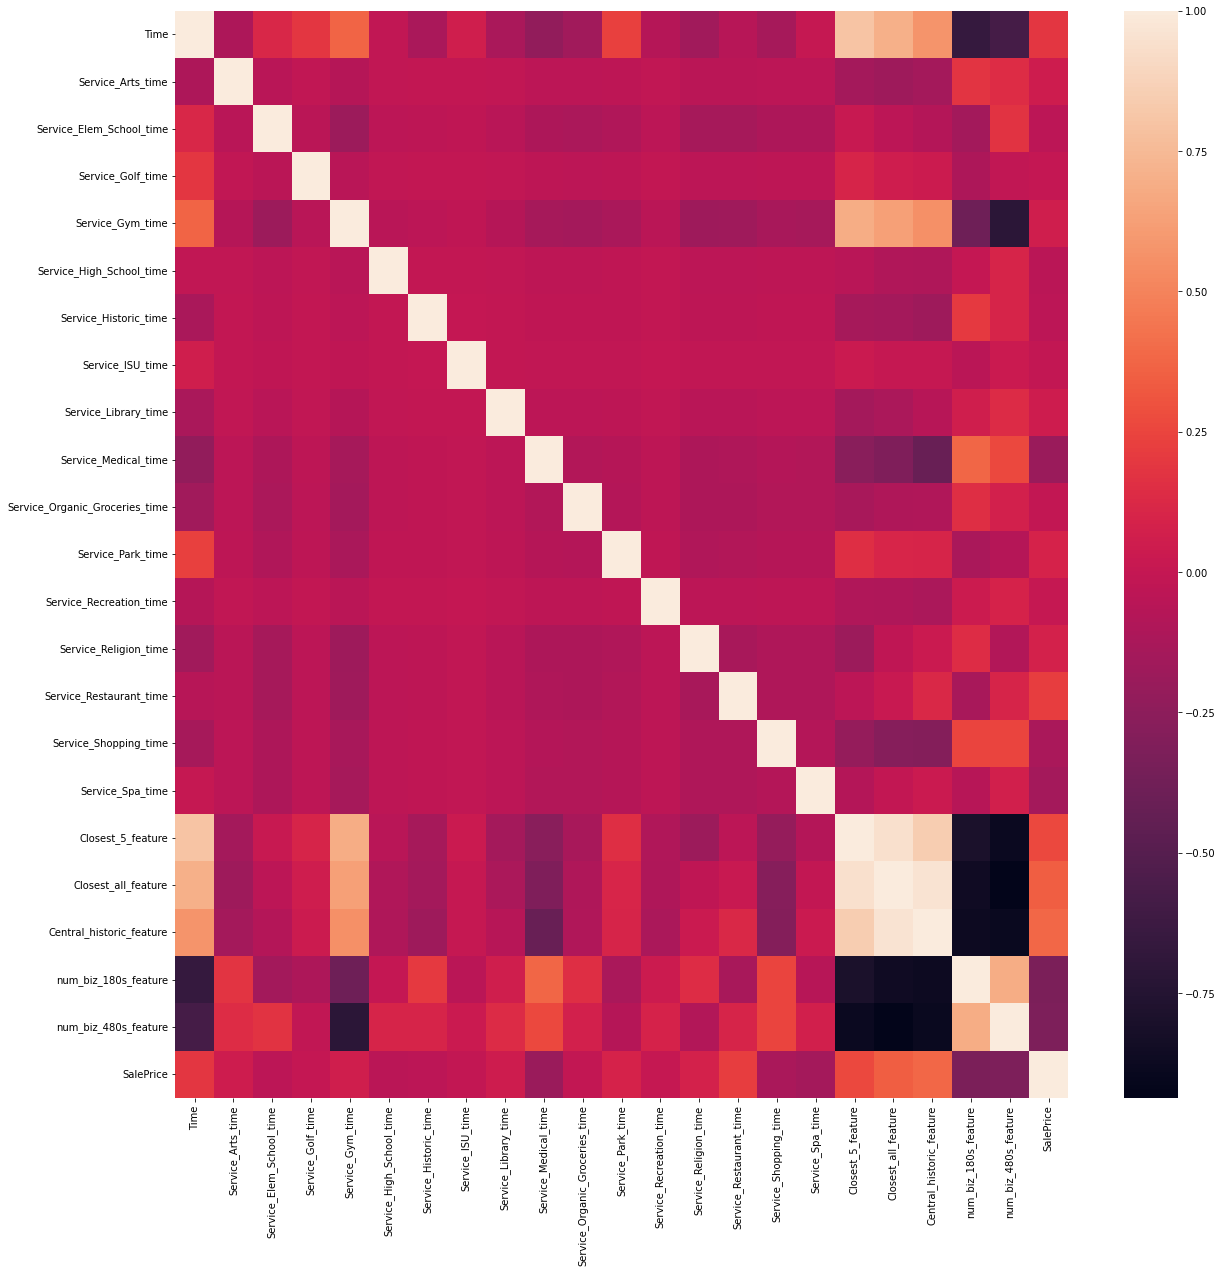

In [215]:
EDA_report(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
    .join(df_dist_time_all.SalePrice)
)

In [162]:
get_vif(pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
)

[5.268192423028085,
 20.458059093474734,
 141.839283957568,
 15.560523086480124,
 188.74737072310091,
 13.5260437355077,
 9.569809394514744,
 4.4281520946978805,
 23.449158449802564,
 85.49954401139367,
 90.38328993033853,
 61.58293666896477,
 12.210383887685447,
 119.7838214472846,
 125.3574147008679,
 73.04247022526377,
 83.33215947956525,
 39.35797481205091,
 144.490975823461,
 63.82612134920185,
 9.685768846311124,
 21.37406298905848]

In [176]:
df_house.GarageType.value_counts()

Attachd    353
Detachd    166
None        40
No Data     30
BuiltIn     28
Basment     11
Carport      3
2 Types      2
Name: GarageType, dtype: int64

In [182]:
df_house.filter(regex = "Yr|_Ext|Has|Area|SF|Cars|Fireplaces|GrType|HsStyle").drop(["TtlVal_AsrYr", "YrSold_YYYY"], axis = 1)

Rcrd_Yr  Inst1_Yr   LotArea  YrBuilt  TtlBsmtSF  Fireplaces  PoolArea  \
SaleID                                                                          
2        2021.0    2021.0   12493.0      0.0        0.0         0.0       0.0   
3        2021.0    2021.0    9595.0   2020.0     1487.0         1.0       0.0   
18       2021.0    2021.0   13596.0   2020.0     1545.0         1.0       0.0   
19       2021.0    2021.0   10890.0      0.0        0.0         0.0       0.0   
20       2021.0    2021.0   10842.0      0.0        0.0         0.0       0.0   
...         ...       ...       ...      ...        ...         ...       ...   
22743    2021.0    2021.0   10776.0   1991.0      950.0         0.0       0.0   
22749    2021.0    2021.0   12395.0   1984.0      864.0         0.0       0.0   
22756    2021.0    2021.0   10463.0   1991.0      962.0         0.0       0.0   
22768    2021.0    2021.0   10457.0   1969.0      784.0         1.0       0.0   
22888    2021.0    2021.0  101059.0   1885.0      520.0         0.0       0.0   

        GarYrBlt  Cars  GarageArea  TotalArea  TotalArea_Gar  Has_Fireplace  \
SaleID                                                                        
2            0.0   0.0         0.0        0.0            0.0              0   
3         2020.0   3.0       641.0     2974.0         3615.0              1   
18        2020.0   3.0       640.0     3090.0         3730.0              1   
19           0.0   0.0         0.0        0.0            0.0              0   
20           0.0   0.0         0.0        0.0            0.0              0   
...          ...   ...         ...        ...            ...            ...   
22743     2001.0   2.0       747.0     1929.0         2676.0              0   
22749     1984.0   2.0       484.0     1753.0         2237.0              0   
22756     1993.0   1.0       384.0     1963.0         2347.0              0   
22768     1969.0   2.0       898.0     2415.0         3313.0              1   
22888        0.0   0.0         0.0     2356.0         2356.0              0   

        Has_Garage  Has_Bsmt  AsbShng_Ext  BrkComm_Ext  BrkFace_Ext  \
SaleID                                                                
2                0         0            0            0            0   
3                1         1            0            0            0   
18               1         1            0            0            0   
19               0         0            0            0            0   
20               0         0            0            0            0   
...            ...       ...          ...          ...          ...   
22743            1         1            0            0            0   
22749            1         1            0            0            0   
22756            1         1            0            0            0   
22768            1         1            0            0            0   
22888            0         1            0            0            0   

        CemntBd_Ext  HdBoard_Ext  ImStucc_Ext  MetalSd_Ext  No Data_Ext  \
SaleID                                                                    
2                 0            0            0            0            2   
3                 0            0            0            0            0   
18                0            0            0            0            0   
19                0            0            0            0            2   
20                0            0            0            0            2   
...             ...          ...          ...          ...          ...   
22743             0            1            0            0            0   
22749             0            1            0            0            0   
22756             0            1            0            0            0   
22768             0            0            0            0            0   
22888             0            0            0            0            0   

        Plywood_Ext  Stone

# Creating Master DataFrame with all fields + all feature engineered fields

In [20]:
df_feature_all = (pd.get_dummies(
                df_temp.loc[df_temp.groupby("SaleID").Time.idxmin()],
                columns = ["Service"]
                )
    .set_index("SaleID")
    .join(pd.DataFrame(selected_features_dict))
    .join(df_house.filter(regex = "Yr|_Ext|Has|Area|SF|Cars|Fireplaces|GrType|HsStyle").drop(["YrSold_YYYY"], axis = 1))
)
#df_feature_all.to_csv("df_feature_all.csv")

In [208]:
#Should have been done earlier in feature engineering (THIS HAS BEEN MOVED TO FEATURE ENGINEERING)
#df_feature_all.rename(columns = {col: col.replace(" ", "_").replace("1", "one").replace("2", "two").replace("5", "five") for col in df_feature_all.columns}, inplace = True)

Time  Service_Arts_time  Service_Elem_School_time  \
count  633.000000         633.000000                633.000000   
mean   146.818799           0.018957                  0.129542   
std     84.844802           0.136482                  0.336064   
min      1.300000           0.000000                  0.000000   
25%     83.500000           0.000000                  0.000000   
50%    118.000000           0.000000                  0.000000   
75%    203.800000           0.000000                  0.000000   
max    371.800000           1.000000                  1.000000   

       Service_Golf_time  Service_Gym_time  Service_High_School_time  \
count         633.000000        633.000000                633.000000   
mean            0.014218          0.189573                  0.012638   
std             0.118482          0.392273                  0.111796   
min             0.000000          0.000000                  0.000000   
25%             0.000000          0.000000                  0.000000   
50%             0.000000          0.000000                  0.000000   
75%             0.000000          0.000000                  0.000000   
max             1.000000          1.000000                  1.000000   

       Service_Historic_time  Service_ISU_time  Service_Library_time  \
count             633.000000        633.000000            633.000000   
mean                0.007899          0.003160              0.020537   
std                 0.088594          0.056165              0.141941   
min                 0.000000          0.000000              0.000000   
25%                 0.000000          0.000000              0.000000   
50%                 0.000000          0.000000              0.000000   
75%                 0.000000          0.000000              0.000000   
max                 1.000000          1.000000              1.000000   

       Service_Medical_time  Service_Organic_Groceries_time  \
count            633.000000                      633.000000   
mean               0.077409                        0.083728   
std                0.267451                        0.277199   
min                0.000000                        0.000000   
25%                0.000000                        0.000000   
50%                0.000000                        0.000000   
75%                0.000000                        0.000000   
max                1.000000                        1.000000   

       Service_Park_time  Service_Recreation_time  Service_Religion_time  \
count         633.000000               633.000000             633.000000   
mean            0.058452                 0.011058               0.115324   
std             0.234781                 0.104659               0.319665   
min             0.000000                 0.000000               0.000000   
25%             0.000000                 0.000000               0.000000   
50%             0.000000                 0.000000               0.000000   
75%             0.000000                 0.000000               0.000000   
max             1.000000                 1.000000               1.000000   

       Service_Restaurant_time  Service_Shopping_time  Service_Spa_time  \
count               633.000000             633.000000        633.000000   
mean                  0.112164               0.069510          0.075829   
std                   0.315818               0.254521          0.264934   
min                   0.000000               0.000000          0.000000   
25%                   0.000000               0.000000          0.000000   
50%                   0.000000               0.000000          0.000000   
75%                   0.000000               0.000000          0.000000   
max                   1.000000               1.000000          1.000000   

       Closest_five_feature  Closest_all_feature  Central_historic_feature  \
count            633.000000           633.000000                633.000000   
mean             216.309131        

Field correlation with SalePrice
SalePrice                 1.000000
TotalArea_Gar             0.820323
TotalArea                 0.798409
Cars                      0.701327
TtlBsmtSF                 0.693831
                            ...   
No_Data_GrType           -0.263569
No_Data_HsStyle          -0.265643
Detachd_GrType           -0.313002
num_biz_480s_feature     -0.322112
num_biz_one80s_feature   -0.327461
Name: SalePrice, Length: 69, dtype: float64
------------------------------

Random Forest Feature Importances
                        Name Importance
33             TotalArea_Gar   0.709757
32                 TotalArea   0.058145
25                   YrBuilt   0.042514
19  Central_historic_feature   0.031706
29                  GarYrBlt   0.027919
..                       ...        ...
55            Carport_GrType   0.000009
44               No_Data_Ext   0.000005
42               ImStucc_Ext   0.000003
51          two_Types_GrType   0.000002
46                 Stone_Ext    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     41.40
Date:                Sat, 24 Jun 2023   Prob (F-statistic):          1.61e-171
Time:                        15:23:52   Log-Likelihood:                -7739.7
No. Observations:                 633   AIC:                         1.560e+04
Df Residuals:                     571   BIC:                         1.588e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                      -2.287e+06   2.01e+06     -1.139      0.255   -6.23e+06    1.66e+06
Time                              62.8925     58.723      1.071      0.285     -52.446     178.231
Service_Arts_time              -6.955e+04   1.26e+05     -0.550      0.582   -3.18e+05    1.79e+05
Service_Elem_School_time       -1.608e+05   1.26e+05     -1.278      0.202   -4.08e+05    8.62e+04
Service_Golf_time              -1.687e+05   1.27e+05     -1.329      0.184   -4.18e+05    8.06e+04
Service_Gym_time               -1.834e+05   1.26e+05     -1.451      0.147   -4.32e+05    6.49e+04
Service_High_School_time       -1.614e+05   1.27e+05     -1.271      0.204   -4.11e+05    8.81e+04
Service_Historic_time          -1.324e+05   1.28e+05     -1.032      0.302   -3.84e+05    1.19e+05
Service_ISU_time               -1.276e+05   1.31e+05     -0.977      0.329   -3.84e+05    1.29e+05
Service_Library_time           -7.598e+04   1.26e+05     -0.603      0.547   -3.24e+05    1.72e+05
Service_Medical_time           -1.532e+05   1.26e+05     -1.215      0.225   -4.01e+05    9.46e+04
Service_Organic_Groceries_time -1.502e+05   1.26e+05     -1.196      0.232   -3.97e+05    9.65e+04
Service_Park_time              -1.538e+05   1.26e+05     -1.218      0.224   -4.02e+05    9.42e+04
Service_Recreation_time        -1.653e+05   1.27e+05     -1.298      0.195   -4.15e+05    8.49e+04
Service_Religion_time          -1.516e+05   1.26e+05     -1.205      0.229   -3.99e+05    9.54e+04
Service_Restaurant_time        -1.376e+05   1.25e+05     -1.101      0.271   -3.83e+05    1.08e+05
Service_Shopping_time          -1.581e+05   1.26e+05     -1.252      0.211   -4.06e+05       9e+04
Service_Spa_time               -1.372e+05   1.26e+05     -1.091      0.276   -3.84e+05     1.1e+05
Closest_five_feature            -218.8232    135.908     -1.610      0.108    -485.763      48.117
Closest_all_feature              282.1479    220.045      1.282      0.200    -150.048     714.344
Central_historic_feature        -111.3989     98.481     -1.131      0.258    -304.827      82.030
num_biz_one80s_feature          1094.9368   1879.599      0.583      0.560   -2596.835    4786.709
num_biz_480s_feature           -4165.7784   2375.531     -1.754      0.080   -8831.623     500.066
Rcrd_Yr                          595.0288    895.494      0.664      0.507   -1163.836    2353.893
Instone_Yr                       595.0285    895.494      0.664      0.507   -1163.835    2353.892
LotArea                            1.4350      0.419      3.427      0.001       0.613       2.257
YrBuilt                          971.0621    191.579      5.069      0.000     594.777    1347.348
TtlBsmtSF                        -54.6954     17.911     -3.054      0.002     -89.874     -19.517
Fireplaces    

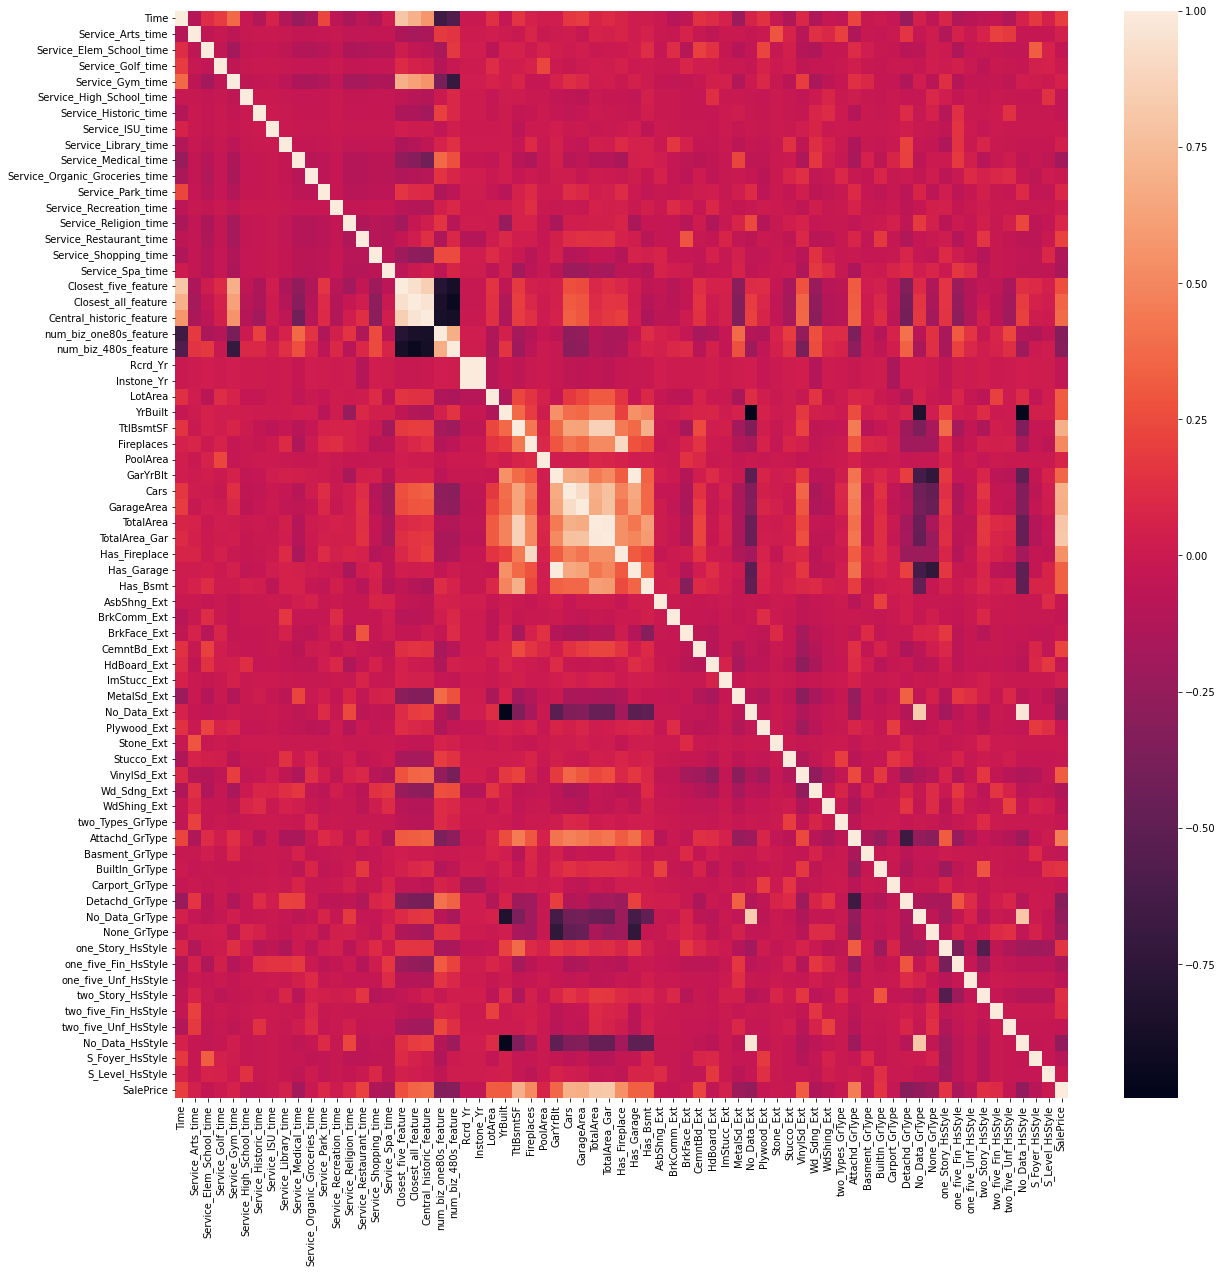

In [216]:
EDA_report(df_feature_all.join(df_house.SalePrice))

In [222]:
X_lassoCV = df_feature_all
y_lassoCV = df_house.SalePrice

In [230]:
lassoCV = LassoCV(normalize = True, max_iter = 10000, random_state = 0)
lassoCV.fit(X_lassoCV, y_lassoCV)
lassoCV_cols = lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]

/Users/lelandmurrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Service_Gym_time  Service_Library_time  Service_Restaurant_time  \
count        633.000000            633.000000               633.000000   
mean           0.189573              0.020537                 0.112164   
std            0.392273              0.141941                 0.315818   
min            0.000000              0.000000                 0.000000   
25%            0.000000              0.000000                 0.000000   
50%            0.000000              0.000000                 0.000000   
75%            0.000000              0.000000                 0.000000   
max            1.000000              1.000000                 1.000000   

       Central_historic_feature        LotArea  Fireplaces        Cars  \
count                633.000000     633.000000  633.000000  633.000000   
mean                 395.439652   10028.298578    0.557662    1.672780   
std                  181.922059    6684.138369    0.626606    0.901528   
min                   16.900000     368.000000    0.000000    0.000000   
25%                  237.700000    7200.000000    0.000000    1.000000   
50%                  418.900000    9566.000000    0.000000    2.000000   
75%                  554.100000   11640.000000    1.000000    2.000000   
max                  720.800000  101059.000000    3.000000    4.000000   

       TotalArea_Gar  Has_Fireplace    Has_Bsmt  BrkFace_Ext  Plywood_Ext  \
count     633.000000     633.000000  633.000000   633.000000   633.000000   
mean     2874.570300       0.491311    0.878357     0.090047     0.121643   
std      1163.285925       0.500320    0.327131     0.372868     0.442292   
min         0.000000       0.000000    0.000000     0.000000     0.000000   
25%      2191.000000       0.000000    1.000000     0.000000     0.000000   
50%      2849.000000       0.000000    1.000000     0.000000     0.000000   
75%      3643.000000       1.000000    1.000000     0.000000     0.000000   
max      6750.000000       1.000000    1.000000     2.000000     2.000000   

       VinylSd_Ext  Detachd_GrType  two_five_Fin_HsStyle  \
count   633.000000      633.000000            633.000000   
mean      0.655608        0.262243              0.003160   
std       0.935349        0.440202              0.056165   
min       0.000000        0.000000              0.000000   
25%       0.000000        0.000000              0.000000   
50%       0.000000        0.000000              0.000000   
75%       2.000000        1.000000              0.000000   
max       2.000000        1.000000              1.000000   

       two_five_Unf_HsStyle      SalePrice  
count            633.000000     633.000000  
mean               0.014218  258405.135861  
std                0.118482  115168.322605  
min                0.000000     900.000000  
25%                0.000000  178000.000000  
50%                0.000000  235000.000000  
75%                0.000000  317000.000000  
max                1.000000  793000.000000

Field correlation with SalePrice
SalePrice                   1.000000
TotalArea_Gar               0.820323
Cars                        0.701327
Has_Fireplace               0.547145
Fireplaces                  0.510575
Central_historic_feature    0.382961
Has_Bsmt                    0.337018
VinylSd_Ext                 0.316795
LotArea                     0.315978
Service_Restaurant_time     0.215112
two_five_Fin_HsStyle        0.098320
Service_Gym_time            0.055249
Service_Library_time        0.041585
BrkFace_Ext                -0.009676
Plywood_Ext                -0.031498
two_five_Unf_HsStyle       -0.041530
Detachd_GrType             -0.313002
Name: SalePrice, dtype: float64
------------------------------

Random Forest Feature Importances
                        Name Importance
7              TotalArea_Gar   0.784706
3   Central_historic_feature   0.104199
4                    LotArea   0.040562
6                       Cars   0.015249
5                 Fireplaces   0.011634


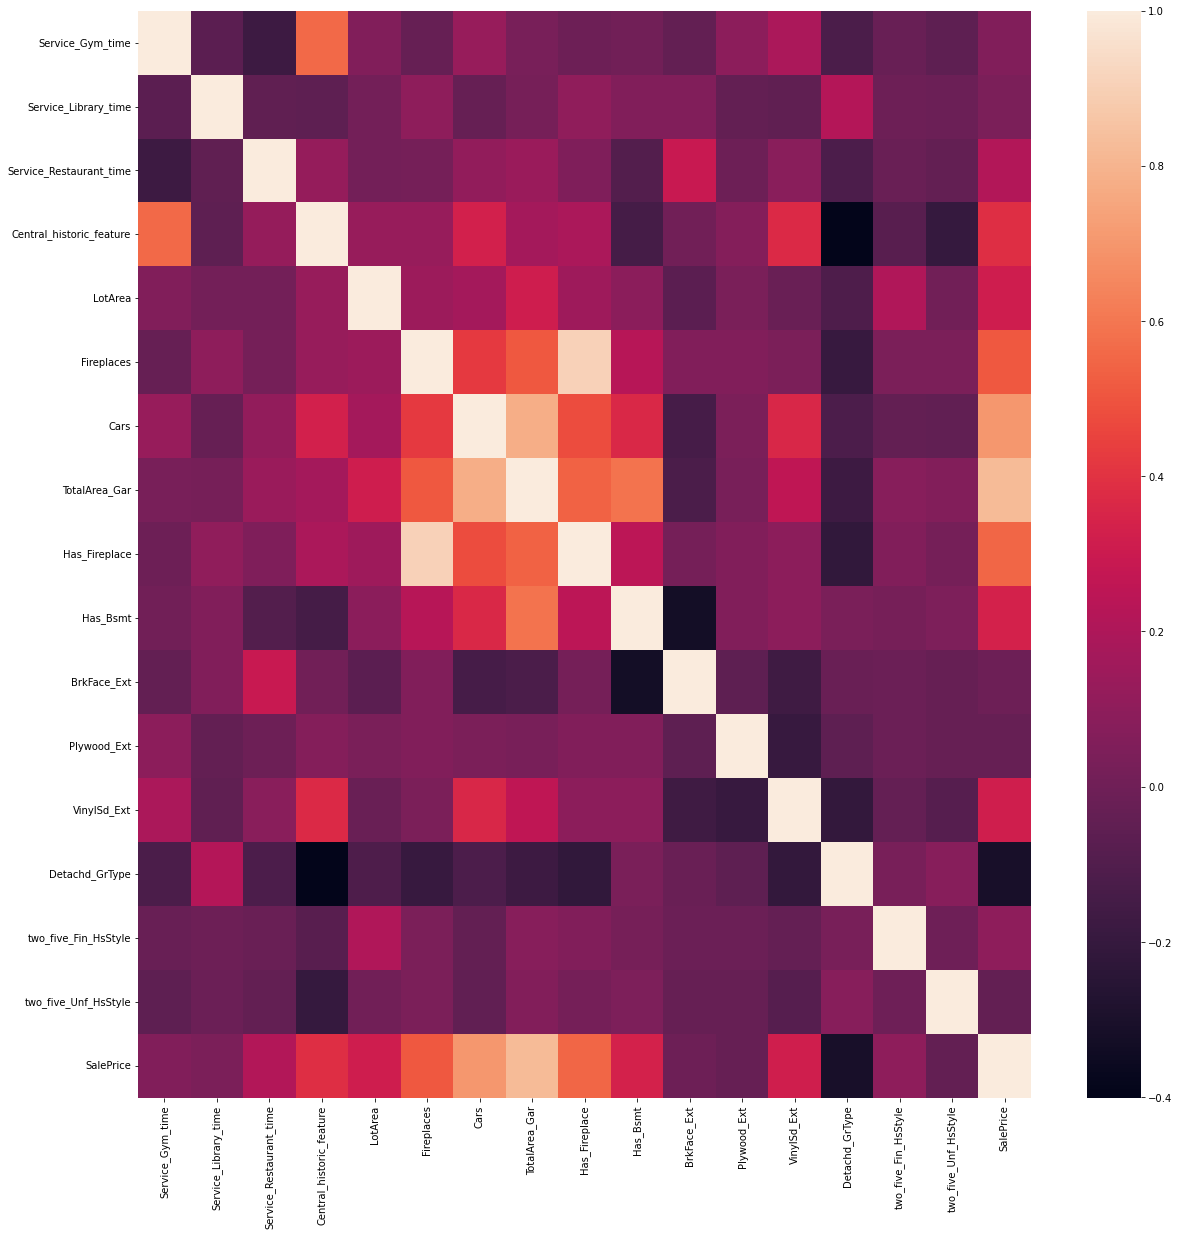

In [279]:
model_EDA = EDA_report(df_feature_all[lassoCV_cols].join(df_house.SalePrice))

In [269]:
selectLassoCV_cols = lassoCV_cols[np.where((lassoCV_cols != "Cars") & (lassoCV_cols != "Has_Fireplace") & (lassoCV_cols != "LotArea") & (lassoCV_cols != "Has_Bsmt"))]
pd.DataFrame(np.array([get_vif(df_feature_all[selectLassoCV_cols]), selectLassoCV_cols])).T

0                         1
0   1.896207          Service_Gym_time
1   1.106911      Service_Library_time
2   1.409212   Service_Restaurant_time
3   6.879479  Central_historic_feature
4   2.619459                Fireplaces
5    7.58259             TotalArea_Gar
6   1.241459               BrkFace_Ext
7   1.173285               Plywood_Ext
8   2.023203               VinylSd_Ext
9   1.402481            Detachd_GrType
10  1.022862      two_five_Fin_HsStyle
11  1.069504      two_five_Unf_HsStyle

In [286]:
df_feature_all[model_EDA.pvalues[model_EDA.pvalues < 0.05].index]

Service_Gym_time  Service_Library_time  Central_historic_feature  \
SaleID                                                                     
2                      0                     0                     606.4   
3                      0                     0                     606.4   
18                     0                     0                     616.2   
19                     0                     0                     619.4   
20                     0                     0                     622.7   
...                  ...                   ...                       ...   
22743                  0                     0                     391.4   
22749                  0                     0                     420.0   
22756                  0                     0                     438.8   
22768                  0                     0                     439.7   
22888                  0                     0                     345.7   

         LotArea  TotalArea_Gar  Has_Bsmt  BrkFace_Ext  Plywood_Ext  \
SaleID                                                                
2        12493.0            0.0         0            0            0   
3         9595.0         3615.0         1            0            0   
18       13596.0         3730.0         1            0            0   
19       10890.0            0.0         0            0            0   
20       10842.0            0.0         0            0            0   
...          ...            ...       ...          ...          ...   
22743    10776.0         2676.0         1            0            0   
22749    12395.0         2237.0         1            0            1   
22756    10463.0         2347.0         1            0            0   
22768    10457.0         3313.0         1            0            0   
22888   101059.0         2356.0         1            0            0   

        Detachd_GrType  two_five_Fin_HsStyle  
SaleID                                        
2                    0                     0  
3                    0                     0  
18                   0                     0  
19                   0                     0  
20                   0                     0  
...                ...                   ...  
22743                1                     0  
22749                0                     0  
22756                1                     0  
22768                0                     0  
22888                0                     0  

[633 rows x 10 columns]

# Random Forest Section

In [52]:
RFR = RandomForestRegressor(random_state = 0)
RFR.fit(df_feature_all, df_house.SalePrice)
RFR.score(df_feature_all, df_house.SalePrice)

0.9766661675340402

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_feature_all, df_house.SalePrice, test_size = 0.2, random_state = 0)

In [54]:
RFR.fit(X_train, y_train)
RFR.score(X_train, y_train), RFR.score(X_test, y_test)

(0.9769940911881261, 0.8700458616878504)

RandomizedSearchCV on Random Forest

In [56]:
params_forest = [{
    "n_estimators": [100, 150, 200],
    "criterion": ['absolute_error'],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": np.linspace(start=2, stop=10, num=10, dtype=int),
    "random_state": [0]}]

grid_search_RF = RandomizedSearchCV(RFR, params_forest, scoring = 'r2', cv=5, n_jobs=-1, verbose = 3, n_iter = 10)
grid_search_RF.fit(df_feature_all, df_house.SalePrice)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END criterion=absolute_error, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=0;, score=0.845 total time=   6.8s
[CV 4/5] END criterion=absolute_error, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=0;, score=0.746 total time=   6.9s
[CV 3/5] END criterion=absolute_error, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=0;, score=0.669 total time=   7.0s
[CV 2/5] END criterion=absolute_error, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=0;, score=0.910 total time=   7.1s
[CV 1/5] END criterion=absolute_error, min_samples_leaf=4, min_samples_split=7, n_estimators=200, random_state=0;, score=0.650 total time=   7.7s
[CV 3/5] END criterion=absolute_error, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=0;, score=0.661 total time=   8.4s
[CV 1/5] END criterion=absolute_error, min_samples_leaf=2, min_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_jobs=-1,
                   param_distributions=[{'criterion': ['absolute_error'],
                                         'min_samples_leaf': range(1, 5),
                                         'min_samples_split': array([ 2,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'n_estimators': [100, 150, 200],
                                         'random_state': [0]}],
                   scoring='r2', verbose=3)

In [57]:
grid_search_RF.best_params_, grid_search_RF.best_score_ 

# Best params and score WITHOUT ASSESSOR:

#({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 7,
#   'min_samples_leaf': 1,
#   'criterion': 'squared_error'},
#  0.6352291041964238)



# WITH ASSESSOR:

# Best Params and Score:

# ({'random_state': 0,
#   'n_estimators': 100,
#   'min_samples_split': 3,
#   'min_samples_leaf': 1,
#   'criterion': 'absolute_error'},
#  0.7895917088205711)

({'random_state': 0,
  'n_estimators': 100,
  'min_samples_split': 3,
  'min_samples_leaf': 1,
  'criterion': 'absolute_error'},
 0.7895917088205711)

In [63]:
find_important_features(grid_search_RF.best_estimator_)

Name Importance
24              TtlVal_AsrYr   0.652248
34             TotalArea_Gar   0.071594
33                 TotalArea   0.029233
26                   YrBuilt   0.027606
25                   LotArea   0.026201
27                 TtlBsmtSF   0.017679
19  Central_historic_feature    0.01669
0                       Time   0.015641
32                GarageArea   0.014298
30                  GarYrBlt   0.012775

In [73]:
best_params = grid_search_RF.best_estimator_.get_params()
RFR.set_params(**best_params)

RandomForestRegressor(criterion='absolute_error', min_samples_split=3,
                      random_state=0)

In [84]:
RFR.fit(X_train, y_train)
RFR.score(X_train, y_train), RFR.score(X_test, y_test)

(0.9746108884081633, 0.8784313702179527)

In [83]:
RFR.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [85]:
find_important_features(RFR).head(10)

Name Importance
24       TtlVal_AsrYr   0.634367
34      TotalArea_Gar    0.10248
33          TotalArea   0.029702
25            LotArea   0.023737
26            YrBuilt   0.021925
27          TtlBsmtSF   0.019165
0                Time   0.017873
32         GarageArea   0.013747
17  Closest_5_feature   0.012869
30           GarYrBlt   0.012536

In [87]:
df_feature_all

Time  Service_Arts_time  Service_Elem_School_time  Service_Golf_time  \
SaleID                                                                          
2        85.5                  0                         0                  0   
3        85.5                  0                         0                  0   
18       95.3                  0                         0                  0   
19       98.5                  0                         0                  0   
20      101.8                  0                         0                  0   
...       ...                ...                       ...                ...   
22743   276.6                  0                         1                  0   
22749   305.2                  0                         1                  0   
22756   324.0                  0                         1                  0   
22768   324.9                  0                         1                  0   
22888   273.6                  0                         0                  0   

        Service_Gym_time  Service_High_School_time  Service_Historic_time  \
SaleID                                                                      
2                      0                         0                      0   
3                      0                         0                      0   
18                     0                         0                      0   
19                     0                         0                      0   
20                     0                         0                      0   
...                  ...                       ...                    ...   
22743                  0                         0                      0   
22749                  0                         0                      0   
22756                  0                         0                      0   
22768                  0                         0                      0   
22888                  0                         0                      0   

        Service_ISU_time  Service_Library_time  Service_Medical_time  \
SaleID                                                                 
2                      0                     0                     0   
3                      0                     0                     0   
18                     0                     0                     0   
19                     0                     0                     0   
20                     0                     0                     0   
...                  ...                   ...                   ...   
22743                  0                     0                     0   
22749                  0                     0                     0   
22756                  0                     0                     0   
22768                  0                     0                     0   
22888                  0                     0                     0   

        Service_Organic_Groceries_time  Service_Park_time  \
SaleID                                                      
2                                    0                  0   
3                                    0                  0   
18                                   0                  0   
19                                   0                  0   
20                                   0                  0   
...                                ...                ...   
22743                                0                  0   
22749                                0                  0   
22756                                0                  0   
22768                                0                  0   
22888                                0                  0   

        Service_Recreation_time  Service_Religion_time  \
SaleID                                                   
2                             0                      1   
3                             0                 

In [86]:
grid_search_RF.score(X_train, y_train), grid_search_RF.score(X_test, y_test)

(0.9742117928163406, 0.9765893228726691)

GridSearchCV on Random Forest

In [104]:
params_forest = [{
    "n_estimators": [50, 100, 150],
    "criterion": ['squared_error', 'absolute_error'],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": [2], #np.linspace(start=2, stop=10, num=10, dtype=int),
    "random_state": [0]}]

grid_search_RF = GridSearchCV(RFR, params_forest, scoring = 'r2', cv=5, n_jobs=-1, verbose = 3)
grid_search_RF.fit(df_feature_all, df_house.SalePrice)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.800 total time=   0.3s
[CV 3/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.215 total time=   0.2s
[CV 2/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.808 total time=   0.3s
[CV 4/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.785 total time=   0.3s
[CV 5/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0;, score=0.524 total time=   0.3s
[CV 1/5] END criterion=squared_error, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0;, score=0.798 total time=   0.5s
[CV 2/5] END criterion=squared_error, min_samples_leaf=1, min_samples_spl

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'criterion': ['squared_error', 'absolute_error'],
                          'min_samples_leaf': range(1, 5),
                          'min_samples_split': [2],
                          'n_estimators': [50, 100, 150],
                          'random_state': [0]}],
             scoring='r2', verbose=3)

In [105]:
grid_search_RF.best_params_, grid_search_RF.best_score_

({'criterion': 'absolute_error',
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 100,
  'random_state': 0},
 0.6370987186061243)

In [106]:
grid_search_RF.score(X_test, y_test)

0.9168414709517322

## Support Vector Regressor Section

In [32]:
SVR_model = SVR(epsilon = 1e-4, gamma=1)
SVR_model.fit(X_train, y_train)
SVR_model.score(X_train, y_train), SVR_model.score(X_test, y_test)

(-0.04941923148971483, -0.012640893739327641)

In [30]:
SS = StandardScaler().fit(df_feature_all.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
X_trainSS = SS.transform(X_train.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))
X_testSS = SS.transform(X_test.filter(regex = "Area|SF|TtlVal|Time|Central_historic_feature"))

In [35]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_trainSS, y_train), SVR_model.score(X_testSS, y_test)

(0.7418894008281418, 0.7352245186826292)

RandomizedSearchCV on SVR

In [34]:
SVR_model.set_params(kernel = "linear", C = 221315789.47368422, epsilon = 8.947369473684211e-05)

SVR(C=221315789.47368422, epsilon=8.947369473684211e-05, gamma=1,
    kernel='linear')

In [36]:
best_params = []
best_score = []

for i in range(1):
    print(i)
    params = {
        #'kernel' : ['linear'],
        'C' : np.linspace(1e6, 3e8, 20),
        #'gamma' : np.linspace(1e-15, 1e4, 20),
        'epsilon': np.linspace(1e-10, 1e-4, 20)
    }
    randgrid = RandomizedSearchCV(SVR_model, params, cv = 3, return_train_score = True, n_jobs = -1, verbose = 3, n_iter = 10)
    randgrid.fit(X_trainSS, y_train)
    best_params.append(randgrid.best_params_)
    best_score.append(randgrid.best_score_)

0
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.660, test=0.892) total time=   1.3s
[CV 2/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.793, test=0.562) total time=   2.4s
[CV 3/3] END C=16736842.105263159, epsilon=3.684216842105264e-05;, score=(train=0.767, test=0.679) total time=   3.7s
[CV 3/3] END C=126894736.84210527, epsilon=8.421054210526317e-05;, score=(train=0.767, test=0.679) total time=  12.6s
[CV 2/3] END C=126894736.84210527, epsilon=8.421054210526317e-05;, score=(train=0.793, test=0.563) total time=  17.5s
[CV 1/3] END C=300000000.0, epsilon=3.157901578947369e-05;, score=(train=0.661, test=0.892) total time=  22.2s
[CV 2/3] END C=300000000.0, epsilon=3.157901578947369e-05;, score=(train=0.793, test=0.564) total time=  25.4s
[CV 2/3] END C=252789473.68421054, epsilon=7.368423684210528e-05;, score=(train=0.793, test=0.563) total time=  22.6s
[CV 1/3

In [37]:
best_params, best_score #best we got with X_trainSS params: ([{'epsilon': 8.947369473684211e-05, 'C': 221315789.47368422}], score: [0.6512524018396496])


([{'epsilon': 3.157901578947369e-05, 'C': 300000000.0}], [0.7115883350105673])

In [68]:
SVR_model.fit(X_trainSS, y_train)
SVR_model.score(X_testSS, y_test)

0.7164253807494236

GridSearchCV on SVR

In [46]:
params = {
    'kernel' : ['rbf', 'linear'],
    'C' : np.linspace(1e-4, 1e7, 20),
    'gamma' : np.linspace(1e-15, 1e4, 20),
    'epsilon': np.linspace(1e-8, 1e6, 20)
}

grid = GridSearchCV(SVR_model, params, cv = 10, return_train_score = True, n_jobs = -1, verbose = 3)
ans_SVR = grid.fit(X_trainSS, y_train)

Fitting 10 folds for each of 16000 candidates, totalling 160000 fits
[CV 4/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.044, test=-0.001) total time=   0.0s
[CV 3/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.049, test=-0.065) total time=   0.0s
[CV 6/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.049, test=-0.003) total time=   0.0s
[CV 2/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.044, test=-0.011) total time=   0.0s
[CV 5/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.046, test=-0.201) total time=   0.0s
[CV 1/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=rbf;, score=(train=-0.048, test=-0.092) total time=   0.0s
[CV 2/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=linear;, score=(train=-0.044, test=-0.011) total time=   0.0s
[CV 3/10] END C=0.0001, epsilon=1e-08, gamma=1e-15, kernel=linear;, score=(train=-0.049, test=-0.065) 

KeyboardInterrupt: 

In [112]:
ans_SVR.score(X_testSS, y_test)

0.00218313059514752

In [86]:
#ans_SVR_rbf = copy.deepcopy(ans_SVR)

In [45]:
#ans_SVR_linear= copy.deepcopy(ans_SVR)